In [22]:
import numpy as np
import pysindy as ps
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
from test_data import experiment_data,add_noise,create_data_2d
from error_bounds import *
from sympy import symbols, diff, factorial, Function, prod
import numpy as np

## Higher order finite differences
We want to bound the error for the derivative 1,2, and 3
For this we need to calculate the derivative of the residue and the lagrange polynomial

#### Residue $r_n(x)=\frac{u^{(n+1)}(\xi (x))}{(n+1)!}\prod_{k=0}^n(x-x_k)$

#### Lagrange coefficient $L_{n,k}(x) =\prod_{i=0,i\neq k}^n \frac{x-x_i}{x_k-x_i}$

In [23]:
#Calculates the Lagrangian
def Ln_k(x, n, k):
    Ln_k_expr = prod((x - symbols(f'x_{i}')) / (symbols(f'x_{k}') - symbols(f'x_{i}')) for i in range(0,n+1) if i != k)
    return Ln_k_expr
#Calculates the residue function
def residue(x,n):
    xi = Function('xi')(x)
    u = Function('u')(x)
    expr = u.diff(x, n + 1).subs(x, xi) / factorial(n + 1) * prod(x - symbols('x_{}'.format(i)) for i in range(0,n+1))
    return expr    

In [24]:
"""
n: finite differences order
l: order of the derivative
m: we evaluate the expression at x_m
"""
def residue_derivative(m,n,l):
    x_sympol = symbols('x')
    symbol_values={}
    symbol_values['x'] = 'x_{}'.format(m)
    #Calculate derivative
    residue_expr = residue(x_sympol,n)
    derivative = diff(residue_expr,x_sympol,l)

    residue_expr_xm = residue_expr.subs(symbol_values)
    derivative_xm = derivative.subs(symbol_values)
    return derivative_xm

"""
n: finite differences order
l: order of the derivative
m: we evaluate the expression at x_m
k: number of lagrange coefficient
"""
def lagrange_derivative(m,n,k,l):
    x_sympol = symbols('x')
    symbol_values={}
    symbol_values['x'] = 'x_{}'.format(m)
    
    lagrange_expr = Ln_k(x_sympol,n, k)
    #print(lagrange_expr)
    derivative = diff(lagrange_expr,x_sympol,l)
    
    lagrange_expr_xm = lagrange_expr.subs(symbol_values)
    derivative_xm = derivative.subs(symbol_values)
    return derivative_xm

In [25]:
n,l,m,k = 3,1,1,1
res_der=residue_derivative(m,n,l)
lagrange_der=lagrange_derivative(m,n,k,l)
print(res_der)

(-x_0 + x_1)*(x_1 - x_2)*(x_1 - x_3)*Derivative(u(xi(x_1)), (xi(x_1), 4))/24


### Upper bound derivative
If we assume $\tilde{u}(x)=u(x)+e(x)$ with $e(x)<\epsilon$ then for $p_n(u,x) = \sum_{k=0}^nu(x_k)L_k(x) $: 
$$ | u^{(l)}(x) - p_n^{(l)}(\tilde{u},x) | \leq |r_n^{(l)}(x)| + \epsilon\sum_{k=0}^n|L_k^{(l)}(x)| $$
We call $|r_n^{(l)}(x)|$ the approximation error and $\epsilon\sum_{k=0}^n|L_k^{(l)}(x)|$ the measurement error.

In [26]:
"""
Replaces all derivatives specified with begin_deriv and end_deriv with constants
m is the number of the data point used for the lagrange polynomial
"""    
def replace_u_xi_derivative(m,expression, begin_deriv, end_deriv):
    h=symbols('h')
    x = symbols('x')
    xi = Function('xi')(x)
    u = Function('u')(x)
    replaced_expression=expression
    #Replace all derivatives in u by constant C_u{i}
    for u_lth in range(end_deriv,begin_deriv,-1):
            
            u_derivative = u.diff(x, u_lth).subs(x, xi)
            u_derivative = u_derivative.subs(x,symbols(f"x_{m}")).subs(symbols(f"x_{m}"),h*m)
            #print(f"{u_lth} derivatve: {u_derivative} ")
           # print(f"Before: {replaced_expression} ")
            replaced_expression = replaced_expression.subs(u_derivative, symbols(f"C_u{u_lth}"))
            #print(f"After: {replaced_expression} ")
    #Replace all derivatives in xi by constant C_xi{i}
    #print("---")
    for xi_lth in range(begin_deriv,0,-1):
            xi_derivative = xi.diff(x, xi_lth)
            xi_derivative = xi_derivative.subs(x,symbols(f"x_{m}")).subs(symbols(f"x_{m}"),h*m)
            #print(f"{xi_lth} derivatve: {xi_derivative} ")
            #print(f"Before: {replaced_expression} ")
            replaced_expression = replaced_expression.subs( xi_derivative, symbols(f"C_xi{xi_lth}")  )
            #print(f"After: {replaced_expression} ")
    return replaced_expression

In [27]:
# we only use central differences so m=order_fd/2
def get_measurement_approximation_constants(order_fd, order_derivative,m):
     #Get measurement error
    h=symbols('h')
    x=np.arange(0,order_fd+1)
    symbol_values={}
    symbol_values = {f'x_{i}': x[i]*h for i in range(order_fd+1)}
    C_meas=0.0
    for k in range(order_fd+1):
            lagrange_der=lagrange_derivative(m,order_fd,k,order_derivative)
            value = lagrange_der.subs(symbol_values)
            C_meas += abs(value)

    #Calculate approximation error
    symbol_values = {f'x_{i}': h*x[i] for i in range(order_fd+1)}
    res_expr=residue_derivative(m,order_fd,order_derivative)
    res_der =res_expr.subs(symbol_values)
    res_expr_replaced = replace_u_xi_derivative(m,res_der, order_fd,order_fd+order_derivative+1)
    # Take the absolute value of each term individually
    C_app = sum(abs(term) for term in res_expr_replaced.as_ordered_terms())
    return C_meas,C_app

In [143]:
"""
Cu: We assume that all derivatives of u up order_fd+order_derivative can be bounded by Cu
Cxi: We assume that all derivatives of xi up to order_fd can be bounded by Cxi
h: h is the space between data points
eps: eps is the upper bound on the noise on u |u-u_noise|_infty < eps
order_fd: is the finite difference_order
order_derivative: is the order of the derivative
"""
def upper_bound_central_differences(eps,order_fd,order_derivative,Cu,Cxi,h):
    assert(order_fd%2==0)
    m=int(order_fd/2)
    C_meas,C_app = get_measurement_approximation_constants(order_fd,order_derivative,m)
    #print(C_app,abs(C_meas))
    symbol_values = {f'C_u{i}': Cu for i in range(order_fd+1,order_fd+order_derivative+1)}
    symbol_values.update({f'C_xi{i}': Cxi for i in range(1,order_derivative)})
   # print(symbol_values)
    C_app=C_app.subs(symbol_values)
    #print(C_app,C_meas)
    C_app=C_app.subs(symbols('h'),h)
    C_meas=C_meas.subs(symbols('h'),h)
    #print(C_app,C_meas)
    upper_bound = C_app+eps*C_meas
    return upper_bound

In [125]:
order_fd,order_derivative=4,1
eps=1
Cu,Cxi=1,1
upper_bound_central_differences(eps,order_fd,order_derivative,Cu,Cxi,h=0.01)

150.000000000333

### Test upper bound finite differences

In [126]:
from numpy.linalg import matrix_rank, svd
import pandas as pd
#Create data
n_samples=200
T,X,t,x = create_data_2d(T_start=0, T_end=5, L_x_start=0,L_x_end=5, N_t=n_samples, N_x=n_samples)


a=np.random.randn()
u = np.exp(X-a*T)
ux = u
uxx = u
uxxx = u
ut = -a*u

"""
u = np.cos(X-a*T)
ux = -np.sin(X-a*T)
uxx = -np.cos(X-a*T)
uxxx = np.sin(X-a*T)
ut = a*np.sin(X-a*T)
"""
dx=x[1]-x[0]
Cu= infinity_norm(u)
Cxi =1.0
data = {'Order_derivative': [], 'Order': [], 'Noise level': [], 'eps': [], '|ux-ux_noise|': [], 'bound': []}#,'old_bound': []}

In [127]:
ux_fd = ps.FiniteDifference(order=3,d=1, axis=0, drop_endpoints=False)._differentiate(u, dx)
u_flat, u_x_flat = u.flatten(), ux_fd.flatten()
g= np.concatenate([u_flat.reshape(len(u_flat),1), u_x_flat.reshape(len(u_flat),1)], axis=1)
print(g.shape)
print(f"Matrix rank = {matrix_rank(g)}, svd = {svd(g, compute_uv=False)}")

(40000, 2)
Matrix rank = 2, svd = [3.02366110e+04 1.20503488e-02]


In [146]:
number_noise = 8  # <= 10
noise_levels = [0] + [10 ** (-10 + i) for i in range(0, number_noise - 1)]
orders = range(2, 10, 2)
order_derivative=2

In [147]:
for order_derivative in range(3,4):
    print(f"Order derivative {order_derivative}")
    for order in orders:
        print(f"Order {order}")
    
        for target_noise in noise_levels:
            var = target_noise * np.sqrt(np.mean(np.square(u)))
            noise = np.random.normal(0, var, size=u.shape)
            u_noise = u + noise
            ux_noise = ps.FiniteDifference(order=order,d=order_derivative, axis=0, drop_endpoints=True)._differentiate(u_noise, dx)
            row_mask = ~np.isnan(ux_noise).all(axis=1)
            col_mask = ~np.isnan(ux_noise).all(axis=0)
            eps = infinity_norm(u_noise[row_mask][:, col_mask] - u[row_mask][:, col_mask])
            
            bound = upper_bound_central_differences(eps, order, order_derivative, Cu, Cxi, dx)
            #old_bound = error_bound_finite_diff(eps,dx,Cu,order)
            
            difference = infinity_norm(ux[row_mask][:, col_mask] - ux_noise[row_mask][:, col_mask])
            data['Order_derivative'].append(order_derivative)
            data['Order'].append(order)
            data['Noise level'].append(target_noise)
            data['eps'].append(eps)
            data['|ux-ux_noise|'].append(difference)
            data['bound'].append(bound)
            #data['old_bound'].append(old_bound)

Order derivative 3
Order 2
Order 4
Order 6
Order 8


In [148]:
df_results = pd.DataFrame(data)
df_results.drop_duplicates(subset=['Order_derivative', 'Order', 'Noise level'], inplace=True)

In [151]:
df_results[df_results['Order_derivative']==3]

,Order_derivative,Order,Noise level,eps,|ux-ux_noise|,bound
32,3,2,0.000000e+00,0.000000e+00,8.511203e-02,567.397752692854
33,3,2,1.000000e-10,4.366843e-08,8.529375e-02,567.397752692854
34,3,2,1.000000e-09,4.897066e-07,1.046561e-01,567.397752692854
35,3,2,1.000000e-08,4.813896e-06,4.395831e-01,567.397752692854
36,3,2,1.000000e-07,4.588285e-05,4.520974e+00,567.397752692854
37,3,2,1.000000e-06,4.453994e-04,4.864787e+01,567.397752692854
38,3,2,1.000000e-05,4.786220e-03,4.649808e+02,567.397752692854
39,3,2,1.000000e-04,4.120499e-02,4.355515e+03,567.397752692854
40,3,4,0.000000e+00,0.000000e+00,1.222743e-05,0.0895378523535875
41,3,4,1.000000e-10,4.231360e-08,7.562273e-03,0.0975408089717821


    Order_derivative  Order  Noise level  eps  |ux-ux_noise|  \
32                 3      2          0.0  0.0   8.511203e-02   
40                 3      4          0.0  0.0   1.222743e-05   
48                 3      6          0.0  0.0   5.832970e-08   
56                 3      8          0.0  0.0   6.800144e-08   

                  bound  
32     567.397752692854  
40   0.0895378523535875  
48  1.31886219102463e-5  
56  1.93512806111780e-9  


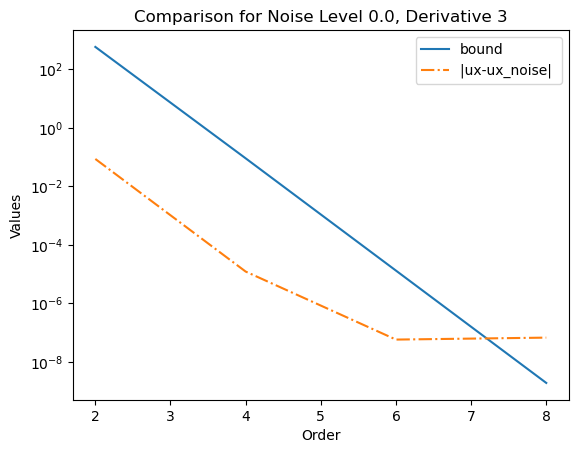

    Order_derivative  Order   Noise level           eps  |ux-ux_noise|  \
33                 3      2  1.000000e-10  4.366843e-08       0.085294   
41                 3      4  1.000000e-10  4.231360e-08       0.007562   
49                 3      6  1.000000e-10  4.277475e-08       0.010354   
57                 3      8  1.000000e-10  4.792387e-08       0.011381   

                 bound  
33    567.397752692854  
41  0.0975408089717821  
49  0.0148451783787399  
57  0.0227860210203147  


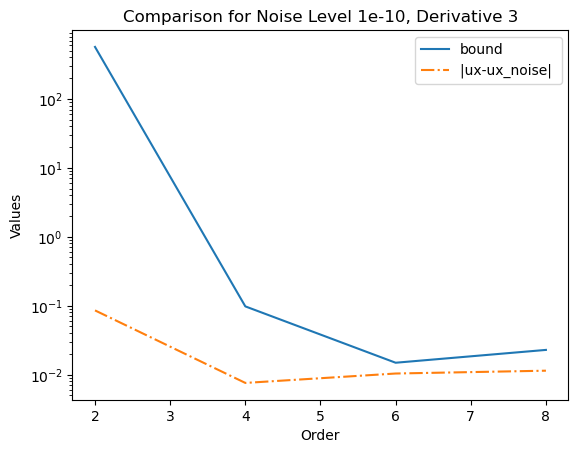

    Order_derivative  Order   Noise level           eps  |ux-ux_noise|  \
34                 3      2  1.000000e-09  4.897066e-07       0.104656   
42                 3      4  1.000000e-09  5.285858e-07       0.076265   
50                 3      6  1.000000e-09  4.583416e-07       0.095672   
58                 3      8  1.000000e-09  4.729326e-07       0.116267   

                bound  
34   567.397752692854  
42  0.189511601918322  
50  0.158941484627096  
58  0.224861879065446  


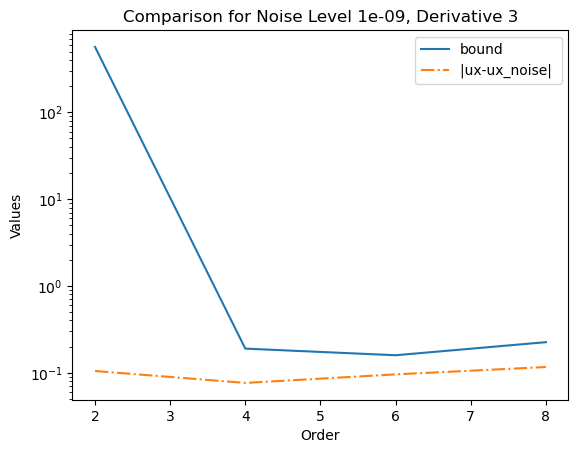

    Order_derivative  Order   Noise level       eps  |ux-ux_noise|  \
35                 3      2  1.000000e-08  0.000005       0.439583   
43                 3      4  1.000000e-08  0.000005       0.920261   
51                 3      6  1.000000e-08  0.000005       1.041701   
59                 3      8  1.000000e-08  0.000004       1.156250   

                bound  
35   567.397752692854  
43  0.951931028790291  
51   1.82812762583672  
59   2.06348286711366  


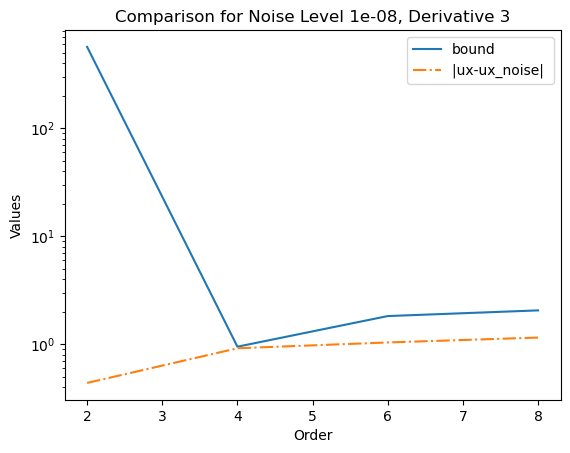

    Order_derivative  Order   Noise level       eps  |ux-ux_noise|  \
36                 3      2  1.000000e-07  0.000046       4.520974   
44                 3      4  1.000000e-07  0.000049       7.497737   
52                 3      6  1.000000e-07  0.000048       9.070295   
60                 3      8  1.000000e-07  0.000045      11.946443   

               bound  
36  567.397752692854  
44  9.34945530679578  
52  16.6645622352288  
60  21.2058191818546  


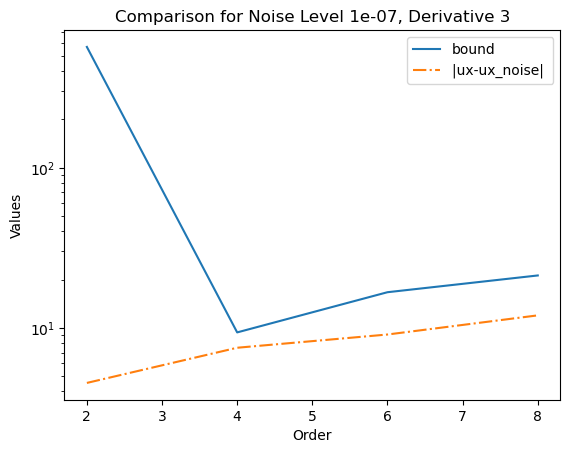

    Order_derivative  Order  Noise level       eps  |ux-ux_noise|  \
37                 3      2     0.000001  0.000445      48.647868   
45                 3      4     0.000001  0.000443      78.447344   
53                 3      6     0.000001  0.000438      97.710386   
61                 3      8     0.000001  0.000473     112.017708   

               bound  
37  567.397752692854  
45  83.9153270453390  
53  151.947842017065  
61  225.084701655102  


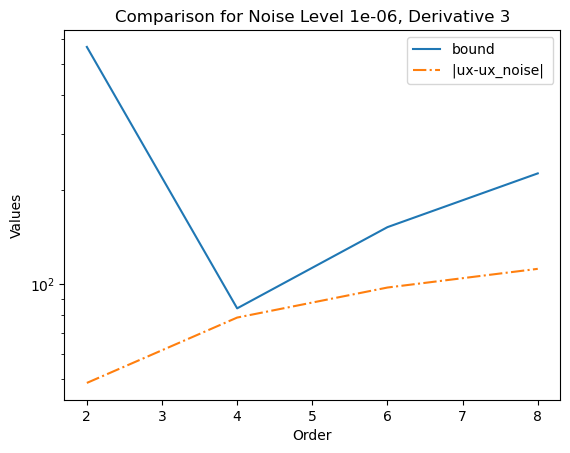

    Order_derivative  Order  Noise level       eps  |ux-ux_noise|  \
38                 3      2      0.00001  0.004786     464.980840   
46                 3      4      0.00001  0.004587     828.180499   
54                 3      6      0.00001  0.004786    1023.223280   
62                 3      8      0.00001  0.004342    1256.384561   

               bound  
38  567.397752692854  
46  867.649565508914  
54  1659.36826426082  
62  2064.64786439774  


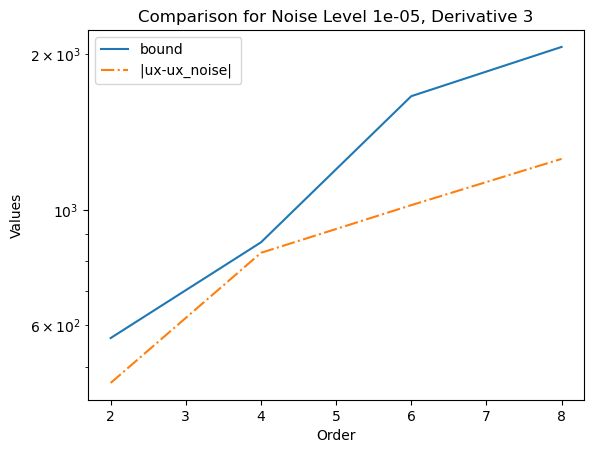

    Order_derivative  Order  Noise level       eps  |ux-ux_noise|  \
39                 3      2       0.0001  0.041205    4355.515084   
47                 3      4       0.0001  0.047485    8005.074769   
55                 3      6       0.0001  0.051119   10513.905112   
63                 3      8       0.0001  0.042460   11334.444609   

               bound  
39  567.397752692854  
47  8981.21592796272  
55  17725.4899658519  
63  20188.0969119630  


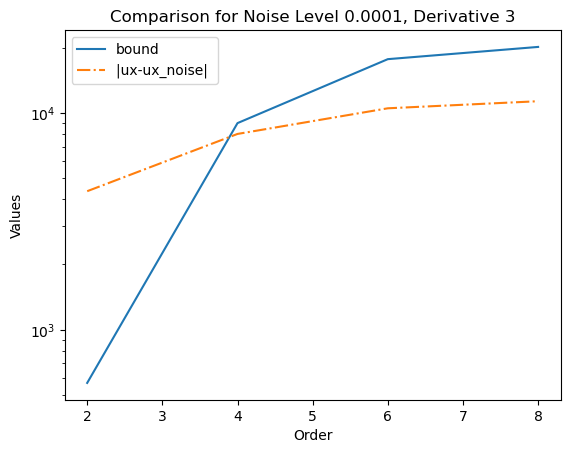

In [152]:
# Get unique noise levels
unique_noise_levels = df_results['Noise level'].unique()
order_derivative=1

# Iterate through each noise level and create a plot
for order_derivative in range(3,4):
    for noise_level in unique_noise_levels:
        df_filtered = df_results[(df_results['Noise level'] == noise_level)][(df_results['Order_derivative'] == order_derivative)]
        print(df_filtered)
        # Set 'Order' as the index
        df_filtered.set_index('Order', inplace=True)
    
        plt.plot(df_filtered['bound'], label=f'bound')
        #plt.plot(df_filtered['old_bound'], label=f'old_bound', linestyle='--')
        plt.plot(df_filtered['|ux-ux_noise|'], label=f'|ux-ux_noise| ', linestyle='-.', )
        plt.legend()
        plt.xlabel('Order')
        plt.ylabel('Values')
        plt.yscale('log')
        plt.title(f'Comparison for Noise Level {noise_level}, Derivative {order_derivative}')
        plt.show()


In [141]:
upper_bound_central_differences(1e-08, 2, 3, Cu, Cxi, dx)

567.397752692854

In [142]:
df_results[df_results['Order_derivative']==3]

,Order_derivative,Order,Noise level,eps,|ux-ux_noise|,bound,1,2,3
96,3,2,0.000000e+00,0.000000e+00,1.049038e-01,Abs(0.441212067781126*C_xi2 + 0.44121206778112...,0,0,0
97,3,2,1.000000e-10,5.210467e-08,1.045998e-01,Abs(0.441212067781126*C_xi2 + 0.44121206778112...,0,0,0
98,3,2,1.000000e-09,5.223305e-07,1.222402e-01,Abs(0.441212067781126*C_xi2 + 0.44121206778112...,0,0,0
99,3,2,1.000000e-08,5.783042e-06,6.363969e-01,Abs(0.441212067781126*C_xi2 + 0.44121206778112...,0,0,0
100,3,2,1.000000e-07,4.925118e-05,5.668317e+00,Abs(0.441212067781126*C_xi2 + 0.44121206778112...,0,0,0
101,3,2,1.000000e-06,5.393808e-04,6.353870e+01,Abs(0.441212067781126*C_xi2 + 0.44121206778112...,0,0,0
102,3,2,1.000000e-05,5.348613e-03,5.073415e+02,Abs(0.441212067781126*C_xi2 + 0.44121206778112...,0,0,0
103,3,2,1.000000e-04,5.085194e-02,5.949002e+03,Abs(0.441212067781126*C_xi2 + 0.44121206778112...,0,0,0
104,3,4,0.000000e+00,0.000000e+00,1.512769e-05,0.110358724132951,0,0,0
105,3,4,1.000000e-10,5.498777e-08,9.037874e-03,0.120758802603211,0,0,0


### Hard code finite differences error

In [ ]:
def derivatie_r(n,order_derivative,h):

def derivatie_L(n,order_derivative,h):
     erg=0.0        
    for j in range(n+1):
        if j!=k:
            tmp =1.0
            for i in range(n+1):
                  if i!=k and i!=j:
                    tmp *=(l-i)/(k-i)
                    #print(f"l-k = {l}-{i}")
            tmp*=1.0/(k-j)
            erg+=tmp
    if order_derivative = 1:
        